## The spam filter

### Introduction

In this example, I develop a **spam filter**, that is, an algorithm that classifies e-mail messages as either spam or non-spam, based on a collection of attributes such as the frequency of certain words or characters. I use data collected at Hewlett-Packard by merging: (a) a collection of spam e-mail from the company postmaster and the individuals who had filed spam, and (b) a collection of non-spam e-mail, extracted from filed work and personal e-mail. 

In this example, I have to take into account that the false positive rate, that is, of non-spam messages wrongly classified as spam, is expected to be very low in a acceptable spam filter. The data set contains data on 4,601 e-mail messages. Among these messages, 1,813 have been classified as spam. The variables are:

* A dummy for the e-mail being considered spam (`spam`).

* 48 numeric variables whose names start with 'word_', followed by a word. They indicate the **frequency**, in percentage scale, with which that word appears in the message. Example: `word_make=0.21`, for a particular message, means that 0.21% of the words in the message match the word 'make'.

* 3 numeric variables indicating, respectively, the **average length** of uninterrupted sequences of capital letters, the length of the longest uninterrupted sequence of capital letters and the total number of capital letters in the message.

### Importing the data

I import the data with the function `read.csv`. The data set has 4,601 rows and 52 columns, all numeric. I print the structure of the data set only for the first and the last five variables.


In [1]:
spam = read.csv('https://raw.githubusercontent.com/iese-bad/DataSci/master/Data/spam.csv')
str(spam[, 1:5])

'data.frame':	4601 obs. of  5 variables:
 $ word_make   : num  0 0.21 0.06 0 0 0 0 0 0.15 0.06 ...
 $ word_address: num  0.64 0.28 0 0 0 0 0 0 0 0.12 ...
 $ word_all    : num  0.64 0.5 0.71 0 0 0 0 0 0.46 0.77 ...
 $ word_3d     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ word_our    : num  0.32 0.14 1.23 0.63 0.63 1.85 1.92 1.88 0.61 0.19 ...


In [2]:
str(spam[, 48:52])

'data.frame':	4601 obs. of  5 variables:
 $ word_conference: num  0 0 0 0 0 0 0 0 0 0 ...
 $ cap_ave        : num  3.76 5.11 9.82 3.54 3.54 ...
 $ cap_long       : int  61 101 485 40 40 15 4 11 445 43 ...
 $ cap_total      : int  278 1028 2259 191 191 54 112 49 1257 749 ...
 $ spam           : int  1 1 1 1 1 1 1 1 1 1 ...


### Building a decision tree

I specify the formula, with a trick for getting it short. The dot on the right side of the formula stands for all the attributes in the data set except the one at the left side. 

In [3]:
fm = spam ~ .

To build the decision tree, I use the function `rpart`, from the package with the same name, to obtain a classifier for these data, based on a decision tree. First of all, I need to load this package, which is not loaded by default.


In [4]:
library(rpart)

Mind that, for `library` to work, the package requested must be installed, which, in practical terms, means that it must be found in a folder called `library` which is located in the same folder as the rest of your R installation. In my Windows computer, the path is `C:\Program files\R\R-3.1.1\library`. In my Macintosh, it is `/Library/Frameworks/R.framework/Versions/3.2/Resources/library`. In the case of `rpart`, there is no problem for calling it, because, although it is not loaded by default, it comes with the default installation.

The syntax of the function `rpart`, if we use the default for all the arguments (brief discussion later), is the same as in `lm`, with the arguments `formula` and `data`.

In [5]:
tree1 = rpart(formula=fm, data=spam)

This produces an `rpart` object, whose contents can be explored with the function `str`, although I do not recommend this, since the output is quite long and difficult, due to the complexity of `rpart` objects.  `summary` can also be used in this case, but the output is quite long, probably too long for a beginner. For a decision tree, if it is not big, the best option is probably to print the `rpart` object itself.

In [6]:
print(tree1)

n= 4601 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 4601 1098.5970000 0.39404480  
    2) word_remove< 0.01 3794  758.9628000 0.27648920  
      4) word_free< 0.135 3108  452.0241000 0.17664090  
        8) word_money< 0.01 2915  341.4751000 0.13550600  
         16) word_000< 0.425 2843  292.4629000 0.11642630  
           32) cap_ave< 3.383 2392  162.1969000 0.07316054 *
           33) cap_ave>=3.383 451  102.0399000 0.34589800  
             66) word_hp>=0.385 142    1.9718310 0.01408451 *
             67) word_hp< 0.385 309   77.2491900 0.49838190  
              134) word_george>=0.035 56    0.9821429 0.01785714 *
              135) word_george< 0.035 253   60.4743100 0.60474310  
                270) word_edu>=0.185 29    0.0000000 0.00000000 *
                271) word_edu< 0.185 224   48.4955400 0.68303570 *
         17) word_000>=0.425 72    7.1111110 0.88888890 *
        9) word_money>=0.01 193   31.1191700 0.79792750 *
      5) word_free>=0.135

Paying a bit of attention, this output is not difficult to read. First, `n=4601` reports the number of training instances. Then, we have one line for each node. In the **root node**, we have `1) root 4601 1098.5970000 0.39404480`. This tells us that we have 4,601 instances in the root node, that the average of the predicted variable (`spam`), that is, the spam rate, is 39.4%, and that the sum of squared residuals (actual value minus mean) is 1098.60. The residual sum of squares is called **deviance** here.

The split at the root node, created by `word_remove`, gives two branches, which lead to nodes 2 and 3. In node 2, which contains the 3,794 instances satisfying `word_remove< 0.01`, has a 27.6% spam rate. The other branch resulting from the root node split ends in node 3, which is reported when all the branching that stems from node 2 is finished. We have there the 807 instances satisfying `word_remove>=0.01`, with a 94.7% spam rate. This is the **optimal split**, meaning the one for which the increase on R-squared is maximum. Another way of presenting the algorithm is saying that the selected split is the one that opens the maximum gap between the spam rates in the two branches (27.6% and 94.7% respectively).

The **leaf nodes** are marked with an asterisk. Take, for instance, node 32. We have there the 2,392 instances that satisfy `word_remove< 0.01 & word_free< 0.135 & word_money< 0.01 & word_000< 0.425 & cap_ave<3.383`. The spam rate in this subset is 7.3%. So the predictive score for all these instances is 0.073. This is what the `predict` function will give us.

Since there are 13 leaf nodes, this tree gives us a partition of the training set in 13 subsets. In each subset, all the instances have the same score. When applied to a new instance, the model places that instance in the appropriate leaf, so that it gets the corresponding score. Note that, to build the partition, we are using only 8 variables, out of the 51 variables available. This is due to the **pruning** performed by the function `rpart`.

The tree can be plotted with the `plot` function, which prints the tree on the graphics device. Then, `text` prints the labels. Playing with the graphical arguments, I have obtained in Figure 1 a polished result. First, with the argument `margin`, I put extra white space around the borders of the tree, to prevent labels to get cut off. Second, the argument ` branch` controls the shape of the branches from parent to child node. Finally, the argument `cex` controls the font size in the labels.


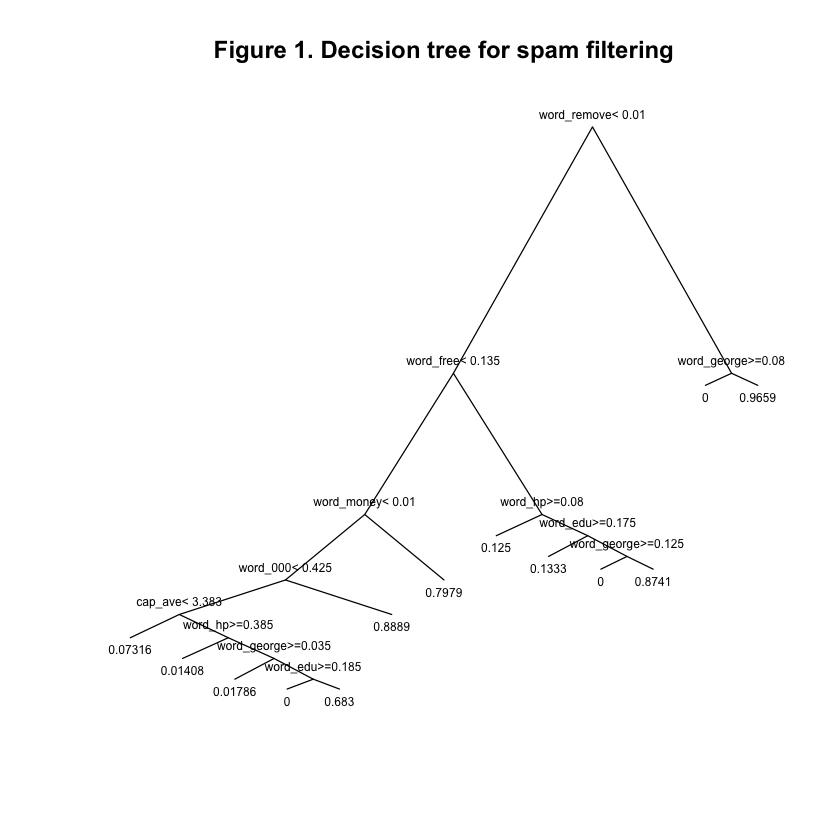

In [7]:
plot(tree1, branch=0, main='Figure 1. Decision tree for spam filtering',
      margin=0.01)
text(tree1, font=1, cex=0.6)

### Predictive scores and confusion matrix

The function `predict` works for `rpart` the same as for `lm`. I first get the scores for the training instances, deriving the confusion matrix from them as in logistic regression. I set the cutoff at 0.5.

In [8]:
score1 = predict(tree1, newdata=spam)
conf1 = table(score1 > 0.5, spam[, 'spam']==1)
print(conf1)

       
        FALSE TRUE
  FALSE  2573  192
  TRUE    215 1621


In [9]:
tp1 = conf1['TRUE', 'TRUE']/sum(conf1[, 'TRUE'])
print(round(tp1, 3))

[1] 0.894


In [10]:
fp1 = conf1['TRUE', 'FALSE']/sum(conf1[, 'FALSE'])
print(round(fp1, 3))

[1] 0.077


Note that, in this case, the data set has been artificially created, by joining two collections which come from different sources. So, the proportion of spam in data is not the real one. This means that a statistic like the accuracy does not make sense. Nevertheless, we can evaluate the classifier examining the two columns of the confusion matrix separately, as we do when we look at the TP and FP rates. 

The TP rate is excellent, but the FP rate is a bit high for a spam filter. Can we improve this with a better cutoff? Instead of exploring this with histograms, it is better to use a table here, since there are only 13 different scores, one for each leaf of the tree. With the function `table`, we get a very clear view.

In [11]:
table(score1, spam[, 'spam'])

                    
score1                  0    1
  0                    66    0
  0.0140845070422535  140    2
  0.0178571428571429   55    1
  0.0731605351170569 2217  175
  0.125                56    8
  0.133333333333333    39    6
  0.683035714285714    71  153
  0.797927461139896    39  154
  0.87410071942446     70  486
  0.888888888888889     8   64
  0.965865992414665    27  764


We see in the table a wide gap between 0.133 and 0.683. This is a by-product of the tree algorithm, which selects the splits so that they produce extreme scores. Here, lowering the cutoff would increase the proportion of positives and, in particular, the FP rate would increase, an undesired effect. But, raising the cutoff, the FP rate would decrease, which could be interesting. It also makes sense from a common sense perspective, because it means that we do not tag a message as spam unless we have stronger evidence.

### Controlling pruning

In `rpart`, pruning is controlled by complexity parameter, specified in the argument `cp`. Any split that does not decrease the overall lack of fit by a factor equal to the specified value `cp` is not attempted. The main role of this parameter is to save computing time by pruning off splits that are obviously not worthwhile. The default is `cp=0.01`.

To show you how this works, I change the specification to `cp=0.005`, getting a tree with 25 leaves, involving 14 variables.

In [12]:
tree2 = rpart(formula=fm, data=spam, cp=0.005)
score2 = predict(tree2, newdata=spam)
conf2 = table(score2 > 0.5, spam[, 'spam']==1)
print(conf2)

       
        FALSE TRUE
  FALSE  2575  119
  TRUE    213 1694


In [13]:
tp2 = conf2['TRUE', 'TRUE']/sum(conf2[, 'TRUE'])
print(round(tp2, 3))

[1] 0.934


In [14]:
fp2 = conf2['TRUE', 'FALSE']/sum(conf2[, 'FALSE'])
print(round(fp2, 3))

[1] 0.076


The confusion matrix looks a bit better, but I should check that this does not come at the price of overfitting (see the homework below.

### Continuation

1. Develop a spam filter based on a logistic regression equation and compare your model with the model presented in the example.

2. Broadly speaking, the **validation** of a model consists in checking that the model works as expected on data which have not been used to develop it. In the simplest approach to validation, we develop the model in a **training set**, trying it on a **test set**. The training and test sets can be predefined (e.g. January and February data) or can be obtained from a **random split** of a unique data set. Validate the models obtained for this example using a 50-50 split. In R, a random selection of one half of the rows of a data set `df` with `N` rows can be done with `train = sample(1:N, size=N/2, replace=FALSE)`. Then, the training set would be `df[train, ]` and the test set `df[-train, ]`.

3. Drop the three `cap_` variables and binarize all the `word_` variables, transforming them into dummies for the occurrence of the corresponding word. Develop a spam filter using this binarized data set and compare your results with those presented in this notbook.